In [25]:
import pandas as pd

In [ ]:
df_1 = pd.read_csv('./training_data_09-20-2022-19-52-14.csv')
df = pd.concat([df_1])

# Analyse Data

In [ ]:
df.info()

In [ ]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [ ]:
df = df.astype({'o_left': int, 'o_right': int})   

In [ ]:
df.head()

In [ ]:
df[df['o_left']==1]

# Set Train and test 

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [ ]:
import os
model = Sequential()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.1,
    patience=500,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

X_train.shape

In [ ]:
model.add(Dense(units=10, input_dim=5,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [36]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=8000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping]
         )

Epoch 1/8000
180/180 [==============================] - 1s 2ms/step - loss: 0.4918 - accuracy: 0.5116 - val_loss: 0.3627 - val_accuracy: 0.7457
Epoch 2/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3617 - accuracy: 0.5925 - val_loss: 0.3654 - val_accuracy: 0.8100
Epoch 3/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3585 - accuracy: 0.4685 - val_loss: 0.3563 - val_accuracy: 0.7575
Epoch 4/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3532 - accuracy: 0.5184 - val_loss: 0.3525 - val_accuracy: 0.7286
Epoch 5/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3518 - accuracy: 0.5461 - val_loss: 0.3540 - val_accuracy: 0.8222
Epoch 6/8000
180/180 [==============================] - 0s 993us/step - loss: 0.3471 - accuracy: 0.4432 - val_loss: 0.3558 - val_accuracy: 0.2807
Epoch 7/8000
180/180 [==============================] - 0s 988us/step - loss: 0.3445 - accuracy: 0.4534 - val_loss: 0.3449 - val_accur

180/180 [==============================] - 0s 1ms/step - loss: 0.3226 - accuracy: 0.4460 - val_loss: 0.3264 - val_accuracy: 0.7343
Epoch 58/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3233 - accuracy: 0.3514 - val_loss: 0.3380 - val_accuracy: 0.8348
Epoch 59/8000
180/180 [==============================] - 0s 989us/step - loss: 0.3220 - accuracy: 0.4588 - val_loss: 0.3274 - val_accuracy: 0.8287
Epoch 60/8000
180/180 [==============================] - 0s 986us/step - loss: 0.3228 - accuracy: 0.4157 - val_loss: 0.3319 - val_accuracy: 0.2498
Epoch 61/8000
180/180 [==============================] - 0s 997us/step - loss: 0.3221 - accuracy: 0.3793 - val_loss: 0.3333 - val_accuracy: 0.2286
Epoch 62/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3229 - accuracy: 0.4943 - val_loss: 0.3365 - val_accuracy: 0.5146
Epoch 63/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3220 - accuracy: 0.3604 - val_loss: 0.3290 - val_accuracy: 

180/180 [==============================] - 0s 1ms/step - loss: 0.3109 - accuracy: 0.3310 - val_loss: 0.3216 - val_accuracy: 0.2347
Epoch 114/8000
180/180 [==============================] - 0s 980us/step - loss: 0.3108 - accuracy: 0.3667 - val_loss: 0.3200 - val_accuracy: 0.2567
Epoch 115/8000
180/180 [==============================] - 0s 993us/step - loss: 0.3101 - accuracy: 0.2891 - val_loss: 0.3262 - val_accuracy: 0.2400
Epoch 116/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3108 - accuracy: 0.3235 - val_loss: 0.3191 - val_accuracy: 0.2701
Epoch 117/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3110 - accuracy: 0.3121 - val_loss: 0.3180 - val_accuracy: 0.2445
Epoch 118/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.3095 - accuracy: 0.2657 - val_loss: 0.3199 - val_accuracy: 0.2274
Epoch 119/8000
180/180 [==============================] - 0s 995us/step - loss: 0.3102 - accuracy: 0.3126 - val_loss: 0.3174 - val_accu

Epoch 169/8000
180/180 [==============================] - 0s 989us/step - loss: 0.2921 - accuracy: 0.2703 - val_loss: 0.3063 - val_accuracy: 0.2958
Epoch 170/8000
180/180 [==============================] - 0s 998us/step - loss: 0.2920 - accuracy: 0.2863 - val_loss: 0.3013 - val_accuracy: 0.3267
Epoch 171/8000
180/180 [==============================] - 0s 994us/step - loss: 0.2939 - accuracy: 0.2959 - val_loss: 0.3051 - val_accuracy: 0.3507
Epoch 172/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2918 - accuracy: 0.2954 - val_loss: 0.2998 - val_accuracy: 0.3124
Epoch 173/8000
180/180 [==============================] - 0s 997us/step - loss: 0.2910 - accuracy: 0.2956 - val_loss: 0.2991 - val_accuracy: 0.3149
Epoch 174/8000
180/180 [==============================] - 0s 996us/step - loss: 0.2927 - accuracy: 0.2903 - val_loss: 0.3105 - val_accuracy: 0.4593
Epoch 175/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2921 - accuracy: 0.2867 - val_loss

180/180 [==============================] - 0s 992us/step - loss: 0.2826 - accuracy: 0.5093 - val_loss: 0.2921 - val_accuracy: 0.3181
Epoch 225/8000
180/180 [==============================] - 0s 990us/step - loss: 0.2792 - accuracy: 0.3796 - val_loss: 0.2905 - val_accuracy: 0.3645
Epoch 226/8000
180/180 [==============================] - 0s 990us/step - loss: 0.2776 - accuracy: 0.4037 - val_loss: 0.2887 - val_accuracy: 0.3312
Epoch 227/8000
180/180 [==============================] - 0s 989us/step - loss: 0.2805 - accuracy: 0.4323 - val_loss: 0.2905 - val_accuracy: 0.3283
Epoch 228/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2789 - accuracy: 0.4659 - val_loss: 0.2927 - val_accuracy: 0.3430
Epoch 229/8000
180/180 [==============================] - 0s 996us/step - loss: 0.2805 - accuracy: 0.4096 - val_loss: 0.2888 - val_accuracy: 0.4142
Epoch 230/8000
180/180 [==============================] - 0s 994us/step - loss: 0.2800 - accuracy: 0.5297 - val_loss: 0.2936 - va

180/180 [==============================] - 0s 994us/step - loss: 0.2690 - accuracy: 0.4895 - val_loss: 0.2840 - val_accuracy: 0.5993
Epoch 280/8000
180/180 [==============================] - 0s 1000us/step - loss: 0.2688 - accuracy: 0.5062 - val_loss: 0.2813 - val_accuracy: 0.3987
Epoch 281/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2703 - accuracy: 0.5670 - val_loss: 0.2915 - val_accuracy: 0.5765
Epoch 282/8000
180/180 [==============================] - 0s 990us/step - loss: 0.2712 - accuracy: 0.6774 - val_loss: 0.2796 - val_accuracy: 0.3735
Epoch 283/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2704 - accuracy: 0.5182 - val_loss: 0.2806 - val_accuracy: 0.5419
Epoch 284/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2703 - accuracy: 0.5871 - val_loss: 0.2855 - val_accuracy: 0.6493
Epoch 285/8000
180/180 [==============================] - 0s 988us/step - loss: 0.2724 - accuracy: 0.5468 - val_loss: 0.2802 - v

180/180 [==============================] - 0s 983us/step - loss: 0.2633 - accuracy: 0.4717 - val_loss: 0.2722 - val_accuracy: 0.4231
Epoch 335/8000
180/180 [==============================] - 0s 992us/step - loss: 0.2607 - accuracy: 0.5301 - val_loss: 0.2811 - val_accuracy: 0.4105
Epoch 336/8000
180/180 [==============================] - 0s 995us/step - loss: 0.2611 - accuracy: 0.6356 - val_loss: 0.2844 - val_accuracy: 0.7238
Epoch 337/8000
180/180 [==============================] - 0s 983us/step - loss: 0.2626 - accuracy: 0.5561 - val_loss: 0.2807 - val_accuracy: 0.3694
Epoch 338/8000
180/180 [==============================] - 0s 973us/step - loss: 0.2628 - accuracy: 0.4197 - val_loss: 0.2759 - val_accuracy: 0.5529
Epoch 339/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2625 - accuracy: 0.4202 - val_loss: 0.2719 - val_accuracy: 0.4121
Epoch 340/8000
180/180 [==============================] - 0s 992us/step - loss: 0.2578 - accuracy: 0.4577 - val_loss: 0.2837 - va

180/180 [==============================] - 0s 997us/step - loss: 0.2589 - accuracy: 0.3627 - val_loss: 0.2816 - val_accuracy: 0.3116
Epoch 390/8000
180/180 [==============================] - 0s 997us/step - loss: 0.2525 - accuracy: 0.3719 - val_loss: 0.2707 - val_accuracy: 0.3230
Epoch 391/8000
180/180 [==============================] - 0s 981us/step - loss: 0.2535 - accuracy: 0.3812 - val_loss: 0.2665 - val_accuracy: 0.3137
Epoch 392/8000
180/180 [==============================] - 0s 992us/step - loss: 0.2527 - accuracy: 0.3484 - val_loss: 0.2719 - val_accuracy: 0.5102
Epoch 393/8000
180/180 [==============================] - 0s 990us/step - loss: 0.2528 - accuracy: 0.4042 - val_loss: 0.2670 - val_accuracy: 0.3800
Epoch 394/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2519 - accuracy: 0.3705 - val_loss: 0.2657 - val_accuracy: 0.3873
Epoch 395/8000
180/180 [==============================] - 0s 994us/step - loss: 0.2526 - accuracy: 0.4120 - val_loss: 0.2662 - 

180/180 [==============================] - 0s 981us/step - loss: 0.2449 - accuracy: 0.5374 - val_loss: 0.2583 - val_accuracy: 0.4833
Epoch 445/8000
180/180 [==============================] - 0s 997us/step - loss: 0.2483 - accuracy: 0.4302 - val_loss: 0.2540 - val_accuracy: 0.7396
Epoch 446/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2468 - accuracy: 0.5653 - val_loss: 0.2563 - val_accuracy: 0.4882
Epoch 447/8000
180/180 [==============================] - 0s 988us/step - loss: 0.2461 - accuracy: 0.5283 - val_loss: 0.2567 - val_accuracy: 0.4638
Epoch 448/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2463 - accuracy: 0.6474 - val_loss: 0.2713 - val_accuracy: 0.3434
Epoch 449/8000
180/180 [==============================] - 0s 987us/step - loss: 0.2493 - accuracy: 0.6038 - val_loss: 0.2690 - val_accuracy: 0.6676
Epoch 450/8000
180/180 [==============================] - 0s 991us/step - loss: 0.2504 - accuracy: 0.4560 - val_loss: 0.2520 - va

Epoch 500/8000
180/180 [==============================] - 0s 999us/step - loss: 0.2444 - accuracy: 0.4073 - val_loss: 0.2513 - val_accuracy: 0.3535
Epoch 501/8000
180/180 [==============================] - 0s 991us/step - loss: 0.2408 - accuracy: 0.4357 - val_loss: 0.2575 - val_accuracy: 0.4882
Epoch 502/8000
180/180 [==============================] - 0s 983us/step - loss: 0.2425 - accuracy: 0.3733 - val_loss: 0.2502 - val_accuracy: 0.4365
Epoch 503/8000
180/180 [==============================] - 0s 978us/step - loss: 0.2441 - accuracy: 0.3773 - val_loss: 0.2771 - val_accuracy: 0.2738
Epoch 504/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2424 - accuracy: 0.4537 - val_loss: 0.2549 - val_accuracy: 0.3853
Epoch 505/8000
180/180 [==============================] - 0s 991us/step - loss: 0.2447 - accuracy: 0.3881 - val_loss: 0.2697 - val_accuracy: 0.6314
Epoch 506/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2442 - accuracy: 0.4284 - val_lo

Epoch 556/8000
180/180 [==============================] - 0s 997us/step - loss: 0.2401 - accuracy: 0.3784 - val_loss: 0.2587 - val_accuracy: 0.3169
Epoch 557/8000
180/180 [==============================] - 0s 981us/step - loss: 0.2390 - accuracy: 0.4295 - val_loss: 0.2502 - val_accuracy: 0.3356
Epoch 558/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2403 - accuracy: 0.4622 - val_loss: 0.2575 - val_accuracy: 0.3059
Epoch 559/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2414 - accuracy: 0.4094 - val_loss: 0.2459 - val_accuracy: 0.7274
Epoch 560/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2396 - accuracy: 0.4110 - val_loss: 0.2558 - val_accuracy: 0.5269
Epoch 561/8000
180/180 [==============================] - 0s 999us/step - loss: 0.2390 - accuracy: 0.4833 - val_loss: 0.2509 - val_accuracy: 0.3242
Epoch 562/8000
180/180 [==============================] - 0s 986us/step - loss: 0.2397 - accuracy: 0.4153 - val_loss

Epoch 612/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2385 - accuracy: 0.4070 - val_loss: 0.2490 - val_accuracy: 0.7250
Epoch 613/8000
180/180 [==============================] - 0s 996us/step - loss: 0.2413 - accuracy: 0.4469 - val_loss: 0.2507 - val_accuracy: 0.2880
Epoch 614/8000
180/180 [==============================] - 0s 997us/step - loss: 0.2369 - accuracy: 0.3836 - val_loss: 0.2591 - val_accuracy: 0.5480
Epoch 615/8000
180/180 [==============================] - 0s 998us/step - loss: 0.2347 - accuracy: 0.3836 - val_loss: 0.2404 - val_accuracy: 0.4845
Epoch 616/8000
180/180 [==============================] - 0s 990us/step - loss: 0.2389 - accuracy: 0.3731 - val_loss: 0.2567 - val_accuracy: 0.2925
Epoch 617/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2354 - accuracy: 0.4485 - val_loss: 0.2495 - val_accuracy: 0.3230
Epoch 618/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2375 - accuracy: 0.4248 - val_loss: 

Epoch 668/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2399 - accuracy: 0.3998 - val_loss: 0.2437 - val_accuracy: 0.3755
Epoch 669/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2394 - accuracy: 0.4220 - val_loss: 0.2476 - val_accuracy: 0.3076
Epoch 670/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.3419 - val_loss: 0.2553 - val_accuracy: 0.4459
Epoch 671/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2399 - accuracy: 0.4893 - val_loss: 0.2490 - val_accuracy: 0.3129
Epoch 672/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2365 - accuracy: 0.4560 - val_loss: 0.2420 - val_accuracy: 0.3572
Epoch 673/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2374 - accuracy: 0.4068 - val_loss: 0.2503 - val_accuracy: 0.3210
Epoch 674/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2333 - accuracy: 0.3726 - val_loss: 0.2441 -

180/180 [==============================] - 0s 982us/step - loss: 0.2336 - accuracy: 0.3812 - val_loss: 0.2402 - val_accuracy: 0.2937
Epoch 725/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2334 - accuracy: 0.3850 - val_loss: 0.2405 - val_accuracy: 0.3922
Epoch 726/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2372 - accuracy: 0.4080 - val_loss: 0.2652 - val_accuracy: 0.7555
Epoch 727/8000
180/180 [==============================] - 0s 994us/step - loss: 0.2305 - accuracy: 0.4335 - val_loss: 0.2428 - val_accuracy: 0.3157
Epoch 728/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2332 - accuracy: 0.4113 - val_loss: 0.2378 - val_accuracy: 0.3775
Epoch 729/8000
180/180 [==============================] - 0s 1ms/step - loss: 0.2328 - accuracy: 0.3582 - val_loss: 0.2361 - val_accuracy: 0.4967
Epoch 730/8000
180/180 [==============================] - 0s 976us/step - loss: 0.2294 - accuracy: 0.3970 - val_loss: 0.2428 - val_accu

In [37]:
model_loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

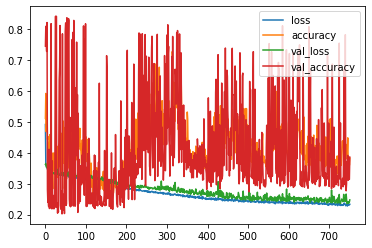

In [38]:
model_loss.plot()

In [20]:
model.save('car_game_model.h5')

In [21]:
import keras
model = keras.models.load_model('car_game_model.h5')

In [22]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1280, 720), car_speed=4, frame_rate=20,
                   road=RoadEnum.THREE, sensor_threshold=200, generate_train_data=False, nn_model=model, 
                   probability_to_decide=0.9)

car_game.start_game()


pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
90
1/1 [==============================] - 0s 110ms/step
[[0.5296863  0.47031364]]
90
1/1 [==============================] - 0s 13ms/step
[[0.48555842 0.5144416 ]]
90
1/1 [==============================] - 0s 13ms/step
[[0.44476855 0.55523145]]
90
1/1 [==============================] - 0s 12ms/step
[[0.46965167 0.5303483 ]]
90
1/1 [==============================] - 0s 13ms/step
[[0.569309 0.430691]]
90
1/1 [==============================] - 0s 12ms/step
[[0.5993333  0.40066674]]
90
1/1 [==============================] - 0s 12ms/step
[[0.7153937 0.2846063]]
90
1/1 [==============================] - 0s 12ms/step
[[0.7750829  0.22491711]]
90
1/1 [==============================] - 0s 12ms/step
[[0.637981 0.362019]]
90
1/1 [==============================] - 0s 13ms/step
[[0.49274635 0.5072536 ]]
90
1/1 [==============================] - 0s 14ms/step
[[0.49274635 0.5072536 ]]
90
1/1